In [1]:
import gradio as gr
import torch
from src.train import train

In [2]:
model,data = train()

Target labels: [0 1]


wandb: Currently logged in as: lamastico2-0 (lamastico2-0-hes-so-valais-wallis) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


lr: 0.001
Epoch 01 | Loss: 0.6857 | Acc: 0.6804 | Val Loss: 0.6827 | Val Acc: 0.7018
Epoch 02 | Loss: 0.6820 | Acc: 0.7214 | Val Loss: 0.6794 | Val Acc: 0.7456
Epoch 03 | Loss: 0.6783 | Acc: 0.7419 | Val Loss: 0.6761 | Val Acc: 0.7544
Epoch 04 | Loss: 0.6745 | Acc: 0.7713 | Val Loss: 0.6728 | Val Acc: 0.7544
Epoch 05 | Loss: 0.6708 | Acc: 0.7859 | Val Loss: 0.6695 | Val Acc: 0.7632
Epoch 06 | Loss: 0.6670 | Acc: 0.7977 | Val Loss: 0.6661 | Val Acc: 0.7807
Epoch 07 | Loss: 0.6632 | Acc: 0.8152 | Val Loss: 0.6627 | Val Acc: 0.7895
Epoch 08 | Loss: 0.6593 | Acc: 0.8299 | Val Loss: 0.6591 | Val Acc: 0.7982
Epoch 09 | Loss: 0.6555 | Acc: 0.8299 | Val Loss: 0.6556 | Val Acc: 0.8158
Epoch 10 | Loss: 0.6516 | Acc: 0.8328 | Val Loss: 0.6520 | Val Acc: 0.8246
Epoch 11 | Loss: 0.6477 | Acc: 0.8416 | Val Loss: 0.6485 | Val Acc: 0.8333
Epoch 12 | Loss: 0.6438 | Acc: 0.8416 | Val Loss: 0.6448 | Val Acc: 0.8421
Epoch 13 | Loss: 0.6399 | Acc: 0.8446 | Val Loss: 0.6412 | Val Acc: 0.8421
Epoch 14 | Loss

Train Accuracy,▁▂▃▃▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
Train Loss,█████▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
Val Accuracy,▁▃▃▃▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████████
Val Loss,█████▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
Train Accuracy,0.93548
Train Loss,0.46214
Val Accuracy,0.88596
Val Loss,0.4721


In [3]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [4]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(data["X_test"])
    y_pred = (y_pred_probs > 0.5).int()

In [5]:
y_pred_np = y_pred.numpy().flatten()
y_true_np = data["y_test"].numpy().flatten()

print(classification_report(y_true_np, y_pred_np, target_names=["malignant", "benign"]))


              precision    recall  f1-score   support

   malignant       0.95      0.88      0.91        42
      benign       0.93      0.97      0.95        72

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



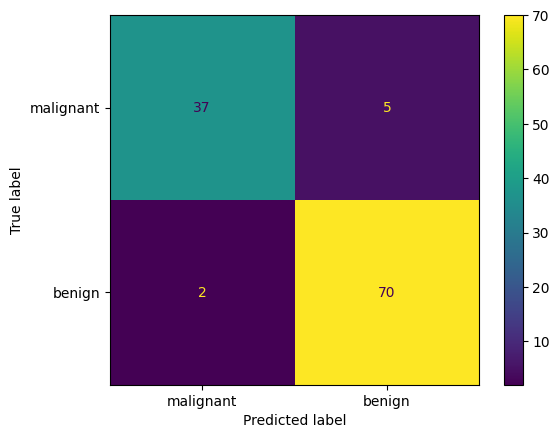

In [6]:
cm = confusion_matrix(y_true_np, y_pred_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["malignant", "benign"])
disp.plot()

In [7]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [8]:
%load_ext autoreload
%autoreload 2
from dexire.dexire import DEXiRE

In [9]:
from dexire.adapters.pytorch_adapter import PyTorchModelAdapter
import numpy as np

In [10]:
adapter = PyTorchModelAdapter(model)
dexire = DEXiRE(model=adapter, class_names=['malignant', 'benign'])
print("y_train unique values:", np.unique(data["y_train"]))
print("class_names:", dexire.class_names)

y_train unique values: [0 1]
class_names: ['malignant', 'benign']


In [11]:
rules = dexire.extract_rules(data["X_train"], data["y_train"])

In [12]:
rules

[]

In [13]:
def greet(name, intensity):
    return "Hello, " + name + "!" * int(intensity)

In [14]:
main = gr.Interface(
    fn=greet,
    inputs=["text", "slider"],
    outputs=["text"],
    api_name="predict"
)

In [15]:
main.launch() # add share=True to have a public server 

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
